In [804]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re

%matplotlib inline

In [805]:
#read in csv files. Only went back to 2000 for now but we can get more later if we want,
fuel_cons_2023 = pd.read_csv("https://www.nrcan.gc.ca/sites/nrcan/files/oee/files/csv/MY2023%20Fuel%20Consumption%20Ratings.csv", encoding="Windows-1252")
fuel_cons_2022 = pd.read_csv("https://www.nrcan.gc.ca/sites/nrcan/files/oee/files/csv/MY2022%20Fuel%20Consumption%20Ratings.csv", encoding="Windows-1252")
fuel_cons_2021 = pd.read_csv("https://www.nrcan.gc.ca/sites/nrcan/files/oee/files/csv/MY2021%20Fuel%20Consumption%20Ratings.csv", encoding="Windows-1252")
fuel_cons_2020 = pd.read_csv("https://www.nrcan.gc.ca/sites/nrcan/files/oee/files/csv/MY2020%20Fuel%20Consumption%20Ratings.csv", encoding="Windows-1252")
fuel_cons_2019 = pd.read_csv("https://www.nrcan.gc.ca/sites/nrcan/files/oee/files/csv/MY2019%20Fuel%20Consumption%20Ratings.csv", encoding="Windows-1252")
fuel_cons_2018 = pd.read_csv("https://www.nrcan.gc.ca/sites/nrcan/files/oee/files/csv/MY2018%20Fuel%20Consumption%20Ratings.csv", encoding="Windows-1252")
fuel_cons_2017 = pd.read_csv("https://www.nrcan.gc.ca/sites/nrcan/files/oee/files/csv/MY2017%20Fuel%20Consumption%20Ratings.csv", encoding="Windows-1252")
fuel_cons_2016 = pd.read_csv("https://www.nrcan.gc.ca/sites/nrcan/files/oee/files/csv/MY2016%20Fuel%20Consumption%20Ratings.csv", encoding="Windows-1252")
fuel_cons_2015 = pd.read_csv("https://www.nrcan.gc.ca/sites/nrcan/files/oee/files/csv/MY2015%20Fuel%20Consumption%20Ratings.csv", encoding="Windows-1252")
fuel_cons_2010_2014 = pd.read_csv("https://www.nrcan.gc.ca/sites/www.rncan.gc.ca/files/oee/files/csv/MY2010-2014%20Fuel%20Consumption%20Ratings%205-cycle.csv", encoding="Windows-1252")
fuel_cons_2005_2009 = pd.read_csv("https://www.nrcan.gc.ca/sites/www.rncan.gc.ca/files/oee/files/csv/MY2005-2009%20Fuel%20Consumption%20Ratings%205-cycle.csv", encoding="Windows-1252")
fuel_cons_2000_2004 = pd.read_csv("https://www.nrcan.gc.ca/sites/www.rncan.gc.ca/files/oee/files/csv/MY2000-2004%20Fuel%20Consumption%20Ratings%205-cycle.csv", encoding="Windows-1252")


C:\Users\apros\AppData\Local\Temp\ipykernel_6300\2667824920.py:2: DtypeWarning: Columns (0,1,2,3,4,6,7,8,9,10,11,12,13,14) have mixed types. Specify dtype option on import or set low_memory=False.
  fuel_cons_2023 = pd.read_csv("https://www.nrcan.gc.ca/sites/nrcan/files/oee/files/csv/MY2023%20Fuel%20Consumption%20Ratings.csv", encoding="Windows-1252")
C:\Users\apros\AppData\Local\Temp\ipykernel_6300\2667824920.py:3: DtypeWarning: Columns (0,1,2,3,4,6,7,8,9,10,11,12,13,14) have mixed types. Specify dtype option on import or set low_memory=False.
  fuel_cons_2022 = pd.read_csv("https://www.nrcan.gc.ca/sites/nrcan/files/oee/files/csv/MY2022%20Fuel%20Consumption%20Ratings.csv", encoding="Windows-1252")
C:\Users\apros\AppData\Local\Temp\ipykernel_6300\2667824920.py:4: DtypeWarning: Columns (0,1,2,3,4,6,7,8,9,10,11,12,13,14) have mixed types. Specify dtype option on import or set low_memory=False.
  fuel_cons_2021 = pd.read_csv("https://www.nrcan.gc.ca/sites/nrcan/files/oee/files/csv/MY2021%

In [806]:
#cleaning

#drop rows of entirely NaN, then cols of entirely Nan, then rows with some NaN
#there was ~50 rows at the bottom with text explaining the data, hence the need for the last drop
cleaner_fuel_cons_2023 = fuel_cons_2023.dropna(axis=0, how='all').dropna(axis=1, how='all').dropna(axis=0)
cleaner_fuel_cons_2022 = fuel_cons_2022.dropna(axis=0, how='all').dropna(axis=1, how='all').dropna(axis=0)
cleaner_fuel_cons_2021 = fuel_cons_2021.dropna(axis=0, how='all').dropna(axis=1, how='all').dropna(axis=0)
cleaner_fuel_cons_2020 = fuel_cons_2020.dropna(axis=0, how='all').dropna(axis=1, how='all').dropna(axis=0)
cleaner_fuel_cons_2019 = fuel_cons_2019.dropna(axis=0, how='all').dropna(axis=1, how='all').dropna(axis=0)
cleaner_fuel_cons_2018 = fuel_cons_2018.dropna(axis=0, how='all').dropna(axis=1, how='all').dropna(axis=0)
cleaner_fuel_cons_2017 = fuel_cons_2017.dropna(axis=0, how='all').dropna(axis=1, how='all').dropna(axis=0)
cleaner_fuel_cons_2016 = fuel_cons_2016.dropna(axis=0, how='all').dropna(axis=1, how='all').dropna(axis=0)
cleaner_fuel_cons_2015 = fuel_cons_2015.dropna(axis=0, how='all').dropna(axis=1, how='all').dropna(axis=0)
cleaner_fuel_cons_2010_2014 = fuel_cons_2010_2014.dropna(axis=0, how='all').dropna(axis=1, how='all').dropna(axis=0)
cleaner_fuel_cons_2005_2009 = fuel_cons_2005_2009.dropna(axis=0, how='all').dropna(axis=1, how='all').dropna(axis=0)
cleaner_fuel_cons_2000_2004 = fuel_cons_2000_2004.dropna(axis=0, how='all').dropna(axis=1, how='all').dropna(axis=0)

#renaming columns. Originally they were split between the first two rows, some got lost in the cleaning.
#useful to get rid of spaces and stuff anyways
col_names = ["model_year", "make", "model", "vehicle_class", "engine_size_L", "cylinders", "transmission", 
             "fuel_type", "city_fuel_cons", "hwy_fuel_cons", "comb_lpkm", "comb_mpg", "co2_emissions", 
             "co2_rating","smog_rating"]

cleaner_fuel_cons_2023.columns = col_names
cleaner_fuel_cons_2022.columns = col_names
cleaner_fuel_cons_2021.columns = col_names
cleaner_fuel_cons_2020.columns = col_names
cleaner_fuel_cons_2019.columns = col_names
cleaner_fuel_cons_2018.columns = col_names
cleaner_fuel_cons_2017.columns = col_names

#older data has less cols, 2016 missing smog rating, 2015 and older also missing co2 rating
cleaner_fuel_cons_2016.columns = col_names[:-1]

cleaner_fuel_cons_2015.columns = col_names[:-2]
cleaner_fuel_cons_2010_2014.columns = col_names[:-2]
cleaner_fuel_cons_2005_2009.columns = col_names[:-2]
cleaner_fuel_cons_2000_2004.columns = col_names[:-2]



In [807]:
#concat datasets and drop index

full_dataset = pd.concat([cleaner_fuel_cons_2023, cleaner_fuel_cons_2022, cleaner_fuel_cons_2021
                            , cleaner_fuel_cons_2020, cleaner_fuel_cons_2019, cleaner_fuel_cons_2018
                            , cleaner_fuel_cons_2017, cleaner_fuel_cons_2016, cleaner_fuel_cons_2015
                            , cleaner_fuel_cons_2010_2014, cleaner_fuel_cons_2005_2009
                            , cleaner_fuel_cons_2000_2004], axis=0)
full_dataset.reset_index(drop=True, inplace=True)

In [808]:
# drop city and highway fuel consumption as combined fuel consumption represents their weighted average (55% city, 45% highway)
# also drop the combined miles per gallon as we will use units of L/100 km
# we will then also drop the CO2 rating and smog rating columns, and focus instead on using CO2 emissions
full_dataset.drop(["city_fuel_cons", "hwy_fuel_cons", "comb_mpg","co2_rating", "smog_rating"], axis=1, inplace=True)
full_dataset

,model_year,make,model,vehicle_class,engine_size_L,cylinders,transmission,fuel_type,comb_lpkm,co2_emissions
0,2023,Acura,Integra,Full-size,1.5,4.0,AV7,Z,7.2,167
1,2023,Acura,Integra A-SPEC,Full-size,1.5,4.0,AV7,Z,7.4,172
2,2023,Acura,Integra A-SPEC,Full-size,1.5,4.0,M6,Z,7.8,181
3,2023,Acura,MDX SH-AWD,SUV: Small,3.5,6.0,AS10,Z,11.2,263
4,2023,Acura,MDX SH-AWD Type S,SUV: Standard,3.0,6.0,AS10,Z,12.4,291
...,...,...,...,...,...,...,...,...,...,...
23477,2004,VOLVO,V70 T5 TURBO,STATION WAGON - MID-SIZE,2.3,5.0,AS5,Z,12.5,288
23478,2004,VOLVO,V70 T5 TURBO,STATION WAGON - MID-SIZE,2.3,5.0,M5,Z,11.8,271
23479,2004,VOLVO,XC70 AWD TURBO,SUV,2.5,5.0,AS5,Z,12.5,288
23480,2004,VOLVO,XC90 2.5T AWD TURBO,SUV,2.5,5.0,AS5,Z,13.0,299


In [809]:
# view data types
print(full_dataset.dtypes)

model_year        object
make              object
model             object
vehicle_class     object
engine_size_L     object
cylinders        float64
transmission      object
fuel_type         object
comb_lpkm         object
co2_emissions     object
dtype: object


In [810]:
# convert strings to numbers
full_dataset["model_year"] = full_dataset["model_year"].astype(int)
cols = ["engine_size_L", "comb_lpkm", "co2_emissions"]
full_dataset[cols] = full_dataset[cols].astype(float)

# checking new data types
print(full_dataset.dtypes)

model_year         int32
make              object
model             object
vehicle_class     object
engine_size_L    float64
cylinders        float64
transmission      object
fuel_type         object
comb_lpkm        float64
co2_emissions    float64
dtype: object


In [811]:
# view list of unique manufacturers
full_dataset["make"].unique()

array(['Acura', 'Alfa Romeo', 'Aston Martin', 'Audi', 'Bentley', 'BMW',
       'Bugatti', 'Buick', 'Cadillac', 'Chevrolet', 'Chrysler', 'Dodge',
       'FIAT', 'Ford', 'Genesis', 'GMC', 'Honda', 'Hyundai', 'Infiniti',
       'Jaguar', 'Jeep', 'Kia', 'Lamborghini', 'Land Rover', 'Lexus',
       'Lincoln', 'Maserati', 'Mazda', 'Mercedes-Benz', 'MINI',
       'Mitsubishi', 'Nissan', 'Ram', 'Rolls-Royce', 'Subaru', 'Toyota',
       'Volkswagen', 'Volvo', 'Porsche', 'ACURA', 'ALFA ROMEO',
       'ASTON MARTIN', 'AUDI', 'BENTLEY', 'BUICK', 'CADILLAC',
       'CHEVROLET', 'CHRYSLER', 'DODGE', 'FORD', 'GENESIS', 'HONDA',
       'HYUNDAI', 'INFINITI', 'JAGUAR', 'JEEP', 'KIA', 'LAMBORGHINI',
       'LAND ROVER', 'LEXUS', 'LINCOLN', 'MASERATI', 'MAZDA',
       'MERCEDES-BENZ', 'MITSUBISHI', 'NISSAN', 'PORSCHE', 'RAM',
       'ROLLS-ROYCE', 'SMART', 'SUBARU', 'TOYOTA', 'VOLKSWAGEN', 'VOLVO',
       'SCION', 'BUGATTI', 'FERRARI', 'HUMMER', 'PONTIAC', 'SUZUKI',
       'SRT', 'SAAB', 'SATURN', 'DAEWO

In [812]:
# Different capitalizations of makes were used in different years. Update for consistency.
full_dataset["make"] = full_dataset["make"].str.lower()
full_dataset["make"] = full_dataset["make"].str.title()

# Also adjust to account for Dodge rebranding their pickup trucks under the Ram name
full_dataset["make"].replace({"Ram": "Dodge"}, inplace = True)

# view updated list of unique manufacturers
full_dataset["make"].unique()

array(['Acura', 'Alfa Romeo', 'Aston Martin', 'Audi', 'Bentley', 'Bmw',
       'Bugatti', 'Buick', 'Cadillac', 'Chevrolet', 'Chrysler', 'Dodge',
       'Fiat', 'Ford', 'Genesis', 'Gmc', 'Honda', 'Hyundai', 'Infiniti',
       'Jaguar', 'Jeep', 'Kia', 'Lamborghini', 'Land Rover', 'Lexus',
       'Lincoln', 'Maserati', 'Mazda', 'Mercedes-Benz', 'Mini',
       'Mitsubishi', 'Nissan', 'Rolls-Royce', 'Subaru', 'Toyota',
       'Volkswagen', 'Volvo', 'Porsche', 'Smart', 'Scion', 'Ferrari',
       'Hummer', 'Pontiac', 'Suzuki', 'Srt', 'Saab', 'Saturn', 'Daewoo',
       'Isuzu', 'Oldsmobile', 'Plymouth'], dtype=object)

In [813]:
# examine which range of years each manufacturer has data for

makes = full_dataset.groupby("make")
for make in makes.groups:
    matches_make = (full_dataset["make"] == make)
    only_current_make_dateset = full_dataset[matches_make]
    min_year = only_current_make_dateset["model_year"].min()
    max_year = only_current_make_dateset["model_year"].max()
    print(f"{make} has vehicle data from {min_year} to {max_year}")


Acura has vehicle data from 2000 to 2023
Alfa Romeo has vehicle data from 2014 to 2023
Aston Martin has vehicle data from 2007 to 2023
Audi has vehicle data from 2000 to 2023
Bentley has vehicle data from 2002 to 2023
Bmw has vehicle data from 2000 to 2023
Bugatti has vehicle data from 2010 to 2023
Buick has vehicle data from 2000 to 2023
Cadillac has vehicle data from 2000 to 2023
Chevrolet has vehicle data from 2000 to 2023
Chrysler has vehicle data from 2000 to 2023
Daewoo has vehicle data from 2000 to 2002
Dodge has vehicle data from 2000 to 2023
Ferrari has vehicle data from 2000 to 2010
Fiat has vehicle data from 2012 to 2023
Ford has vehicle data from 2000 to 2023
Genesis has vehicle data from 2017 to 2023
Gmc has vehicle data from 2000 to 2023
Honda has vehicle data from 2000 to 2023
Hummer has vehicle data from 2006 to 2010
Hyundai has vehicle data from 2000 to 2023
Infiniti has vehicle data from 2000 to 2023
Isuzu has vehicle data from 2000 to 2003
Jaguar has vehicle data fro

In [814]:
# remove data from the datset for manufacturers that didn't make cars from 2000 to 2023
for make in makes.groups:
    matches_make = (full_dataset["make"] == make)
    only_current_make_dataset = full_dataset[matches_make]
    min_year = only_current_make_dataset["model_year"].min()
    max_year = only_current_make_dataset["model_year"].max()
    not_full_range_of_years = ((min_year != 2000) or (max_year != 2023))
    if not_full_range_of_years:
        full_dataset.drop(only_current_make_dataset.index, inplace=True)

full_dataset.reset_index(drop=True, inplace=True)
full_dataset["make"].unique()


array(['Acura', 'Audi', 'Bmw', 'Buick', 'Cadillac', 'Chevrolet',
       'Chrysler', 'Dodge', 'Ford', 'Gmc', 'Honda', 'Hyundai', 'Infiniti',
       'Jaguar', 'Jeep', 'Kia', 'Land Rover', 'Lexus', 'Lincoln', 'Mazda',
       'Mercedes-Benz', 'Nissan', 'Subaru', 'Toyota', 'Volkswagen',
       'Volvo'], dtype=object)

In [815]:
# Next we will look at all the different vehicle classes
full_dataset["vehicle_class"].unique()

array(['Full-size', 'SUV: Small', 'SUV: Standard', 'Compact',
       'Subcompact', 'Station wagon: Small', 'Mid-size',
       'Station wagon: Mid-size', 'Two-seater', 'Pickup truck: Standard',
       'Minivan', 'Pickup truck: Small', 'Special purpose vehicle',
       'Minicompact', 'Van: Passenger', 'COMPACT', 'SUV - SMALL',
       'TWO-SEATER', 'MID-SIZE', 'SUBCOMPACT', 'STATION WAGON - SMALL',
       'FULL-SIZE', 'SUV - STANDARD', 'SPECIAL PURPOSE VEHICLE',
       'PICKUP TRUCK - SMALL', 'VAN - PASSENGER',
       'PICKUP TRUCK - STANDARD', 'MINIVAN', 'STATION WAGON - MID-SIZE',
       'MINICOMPACT', 'SUV', 'VAN - CARGO', 'UL'], dtype=object)

In [816]:
# Different capitalizations and hyphens/colons were used in different years of vehicle_class.
# We are going to simplify into 5 categories: Car, SUV, Van, Truck, and Passenger/Cargo Van
full_dataset["vehicle_class"].replace({"Full-size": "Car",
                                       "SUV: Small": "SUV",
                                       "SUV: Standard": "SUV",
                                       "Compact": "Car",
                                       "Subcompact": "Car",
                                       "Station wagon: Small": "Car",
                                       "Mid-size": "Car",
                                       "Station wagon: Mid-size": "Car",
                                       "Two-seater": "Car",
                                       "Pickup truck: Standard": "Truck",
                                       "Minivan": "Van",
                                       "Pickup truck: Small": "Truck",
                                       "Special purpose vehicle": "Passenger/Cargo Van",
                                       "Minicompact": "Car",
                                       "Van: Passenger": "Passenger/Cargo Van",
                                       "COMPACT": "Car",
                                       "SUV - SMALL": "SUV",
                                       "TWO-SEATER": "Car",
                                       "MID-SIZE": "Car",
                                       "SUBCOMPACT": "Car",
                                       "STATION WAGON - SMALL": "Car",
                                       "FULL-SIZE": "Car",
                                       "SUV - STANDARD": "SUV",
                                       "SPECIAL PURPOSE VEHICLE": "Van",
                                       "PICKUP TRUCK - SMALL": "Truck",
                                       "VAN - PASSENGER": "Passenger/Cargo Van",
                                       "PICKUP TRUCK - STANDARD": "Truck",
                                       "MINIVAN": "Van",
                                       "STATION WAGON - MID-SIZE": "Car",
                                       "MINICOMPACT": "Car",
                                       "SUV": "SUV",
                                       "VAN - CARGO": "Passenger/Cargo Van",
                                       "UL": "SUV"}, inplace = True)
# verify changes
full_dataset["vehicle_class"].unique()

array(['Car', 'SUV', 'Truck', 'Van', 'Passenger/Cargo Van'], dtype=object)

In [817]:
# remove the passenger/cargo van category as these are typically business vehicles
is_passenger_cargo_van = full_dataset["vehicle_class"] == "Passenger/Cargo Van"
only_passenger_cargo_van_dataset = full_dataset[is_passenger_cargo_van]
full_dataset.drop(only_passenger_cargo_van_dataset.index, inplace=True)
full_dataset.reset_index(drop=True, inplace=True)
# verify changes
full_dataset["vehicle_class"].unique()

array(['Car', 'SUV', 'Truck', 'Van'], dtype=object)

In [818]:
# update the fuel types from letters to their actual meanings
full_dataset["fuel_type"].replace({"X": "Regular Gasoline",
                                   "Z": "Premium Gasoline",
                                   "D": "Diesel",
                                   "E": "Ethanol",
                                   "N": "Natural Gas"}, inplace = True)

# verify changes
full_dataset.head()

,model_year,make,model,vehicle_class,engine_size_L,cylinders,transmission,fuel_type,comb_lpkm,co2_emissions
0,2023,Acura,Integra,Car,1.5,4.0,AV7,Premium Gasoline,7.2,167.0
1,2023,Acura,Integra A-SPEC,Car,1.5,4.0,AV7,Premium Gasoline,7.4,172.0
2,2023,Acura,Integra A-SPEC,Car,1.5,4.0,M6,Premium Gasoline,7.8,181.0
3,2023,Acura,MDX SH-AWD,SUV,3.5,6.0,AS10,Premium Gasoline,11.2,263.0
4,2023,Acura,MDX SH-AWD Type S,SUV,3.0,6.0,AS10,Premium Gasoline,12.4,291.0


In [819]:
# make the transmission column more meaningful
# it is currently represented as a combination of letters representing the transmission type, followed by the number of gears

# separate each into the transmission type and gears
def convert_transmission_to_type(s):
    transmission_type = re.findall('([A-Za-z]+)', s)
    return transmission_type[0]

def convert_transmission_to_gears(s):
    transmission_gears = re.findall('\d+', s)
    if (transmission_gears == []):
        transmission_gears = [float('nan')]  
    return transmission_gears[0]

# separate the transmission column into separate columns for transmission type and gears, remove original column
full_dataset["transmission_type"] = full_dataset["transmission"].apply(convert_transmission_to_type)
full_dataset["transmission_gears"] = full_dataset["transmission"].apply(convert_transmission_to_gears)
full_dataset["transmission_gears"] = full_dataset["transmission_gears"].astype(float)
full_dataset.drop(["transmission"], axis=1, inplace=True)

In [820]:
# update the transmission types from abbreviations to their actual meanings
full_dataset["transmission_type"].replace({"A": "Automatic",
                                           "AM": "Automated Manual",
                                           "AS": "Automatic Select Shift",
                                           "AV": "Continuously Variable",
                                           "M": "Manual",}, inplace = True)

# verify changes
full_dataset.head()

,model_year,make,model,vehicle_class,engine_size_L,cylinders,fuel_type,comb_lpkm,co2_emissions,transmission_type,transmission_gears
0,2023,Acura,Integra,Car,1.5,4.0,Premium Gasoline,7.2,167.0,Continuously Variable,7.0
1,2023,Acura,Integra A-SPEC,Car,1.5,4.0,Premium Gasoline,7.4,172.0,Continuously Variable,7.0
2,2023,Acura,Integra A-SPEC,Car,1.5,4.0,Premium Gasoline,7.8,181.0,Manual,6.0
3,2023,Acura,MDX SH-AWD,SUV,3.5,6.0,Premium Gasoline,11.2,263.0,Automatic Select Shift,10.0
4,2023,Acura,MDX SH-AWD Type S,SUV,3.0,6.0,Premium Gasoline,12.4,291.0,Automatic Select Shift,10.0


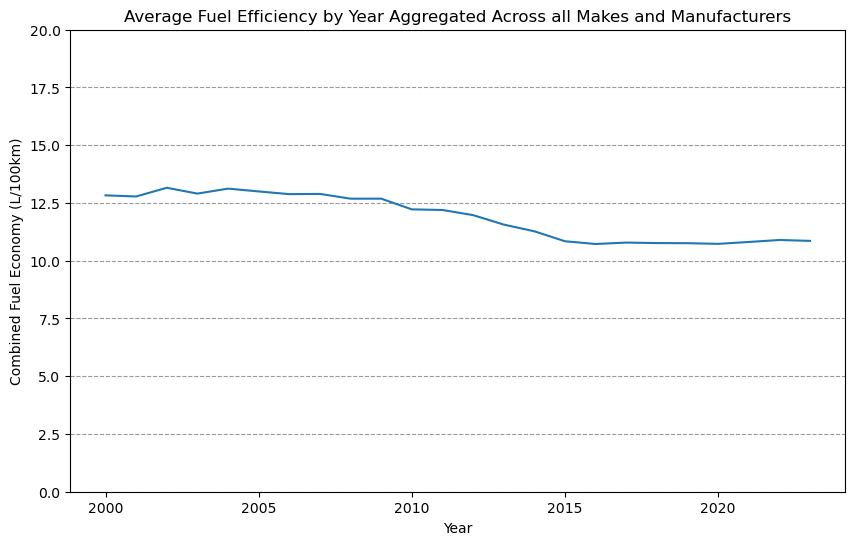

In [821]:
full_dataset_year_as_index = full_dataset.set_index("model_year")
years = full_dataset_year_as_index.groupby("model_year")

ax = years.mean()["comb_lpkm"].plot(figsize=(10, 6))
fig = ax.get_figure()
ax.set_ylim(0, 20)
ax.set_title("Average Fuel Efficiency by Year Aggregated Across all Makes and Manufacturers")
ax.set_xlabel("Year")
ax.set_ylabel("Combined Fuel Economy (L/100km)")
ax.yaxis.grid(True, color="black", alpha = 0.4, linestyle='--')

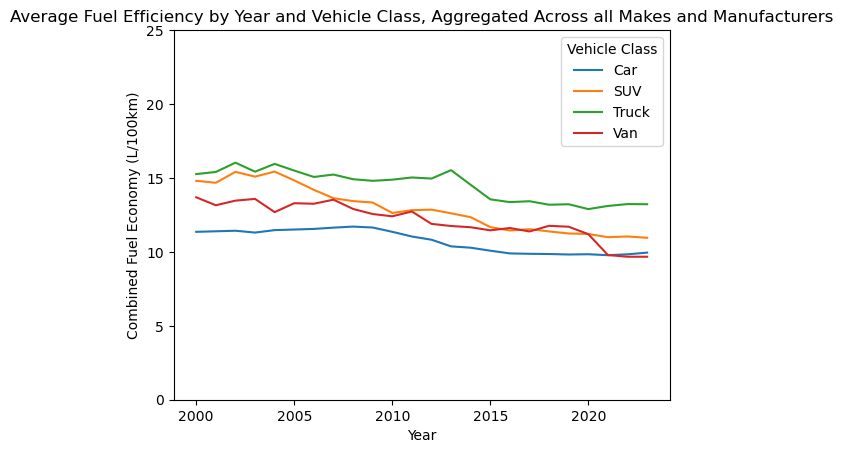

In [822]:
fuel_economy_by_year_and_vehicle_type = full_dataset.pivot_table(index="model_year", columns="vehicle_class", values="comb_lpkm", aggfunc="mean")

ax = fuel_economy_by_year_and_vehicle_type.plot.line()
ax.set_xlabel("Year")
ax.set_ylabel("Combined Fuel Economy (L/100km)")
ax.set_ylim(0, 25)
ax.set_title("Average Fuel Efficiency by Year and Vehicle Class, Aggregated Across all Makes and Manufacturers")
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels, title="Vehicle Class", loc='upper right')

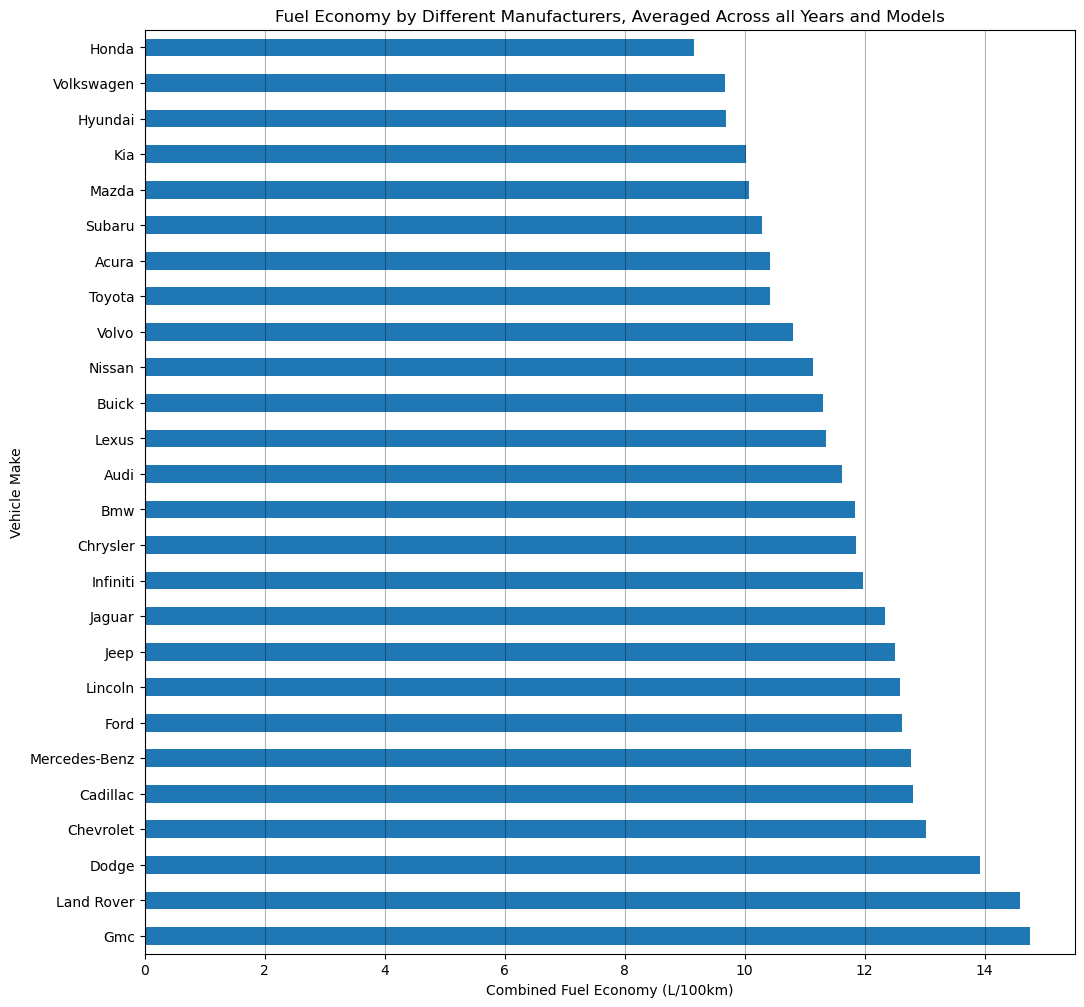

In [824]:
ax = fuel_economy_by_year_and_make.mean().sort_values(ascending=False).plot(kind="barh", figsize=(12, 12))
ax.set_ylabel("Vehicle Make")
ax.set_xlabel("Combined Fuel Economy (L/100km)")
ax.set_title("Fuel Economy by Different Manufacturers, Averaged Across all Years and Models")
plt.grid(c='black', alpha=0.3)
ax.yaxis.grid(False)

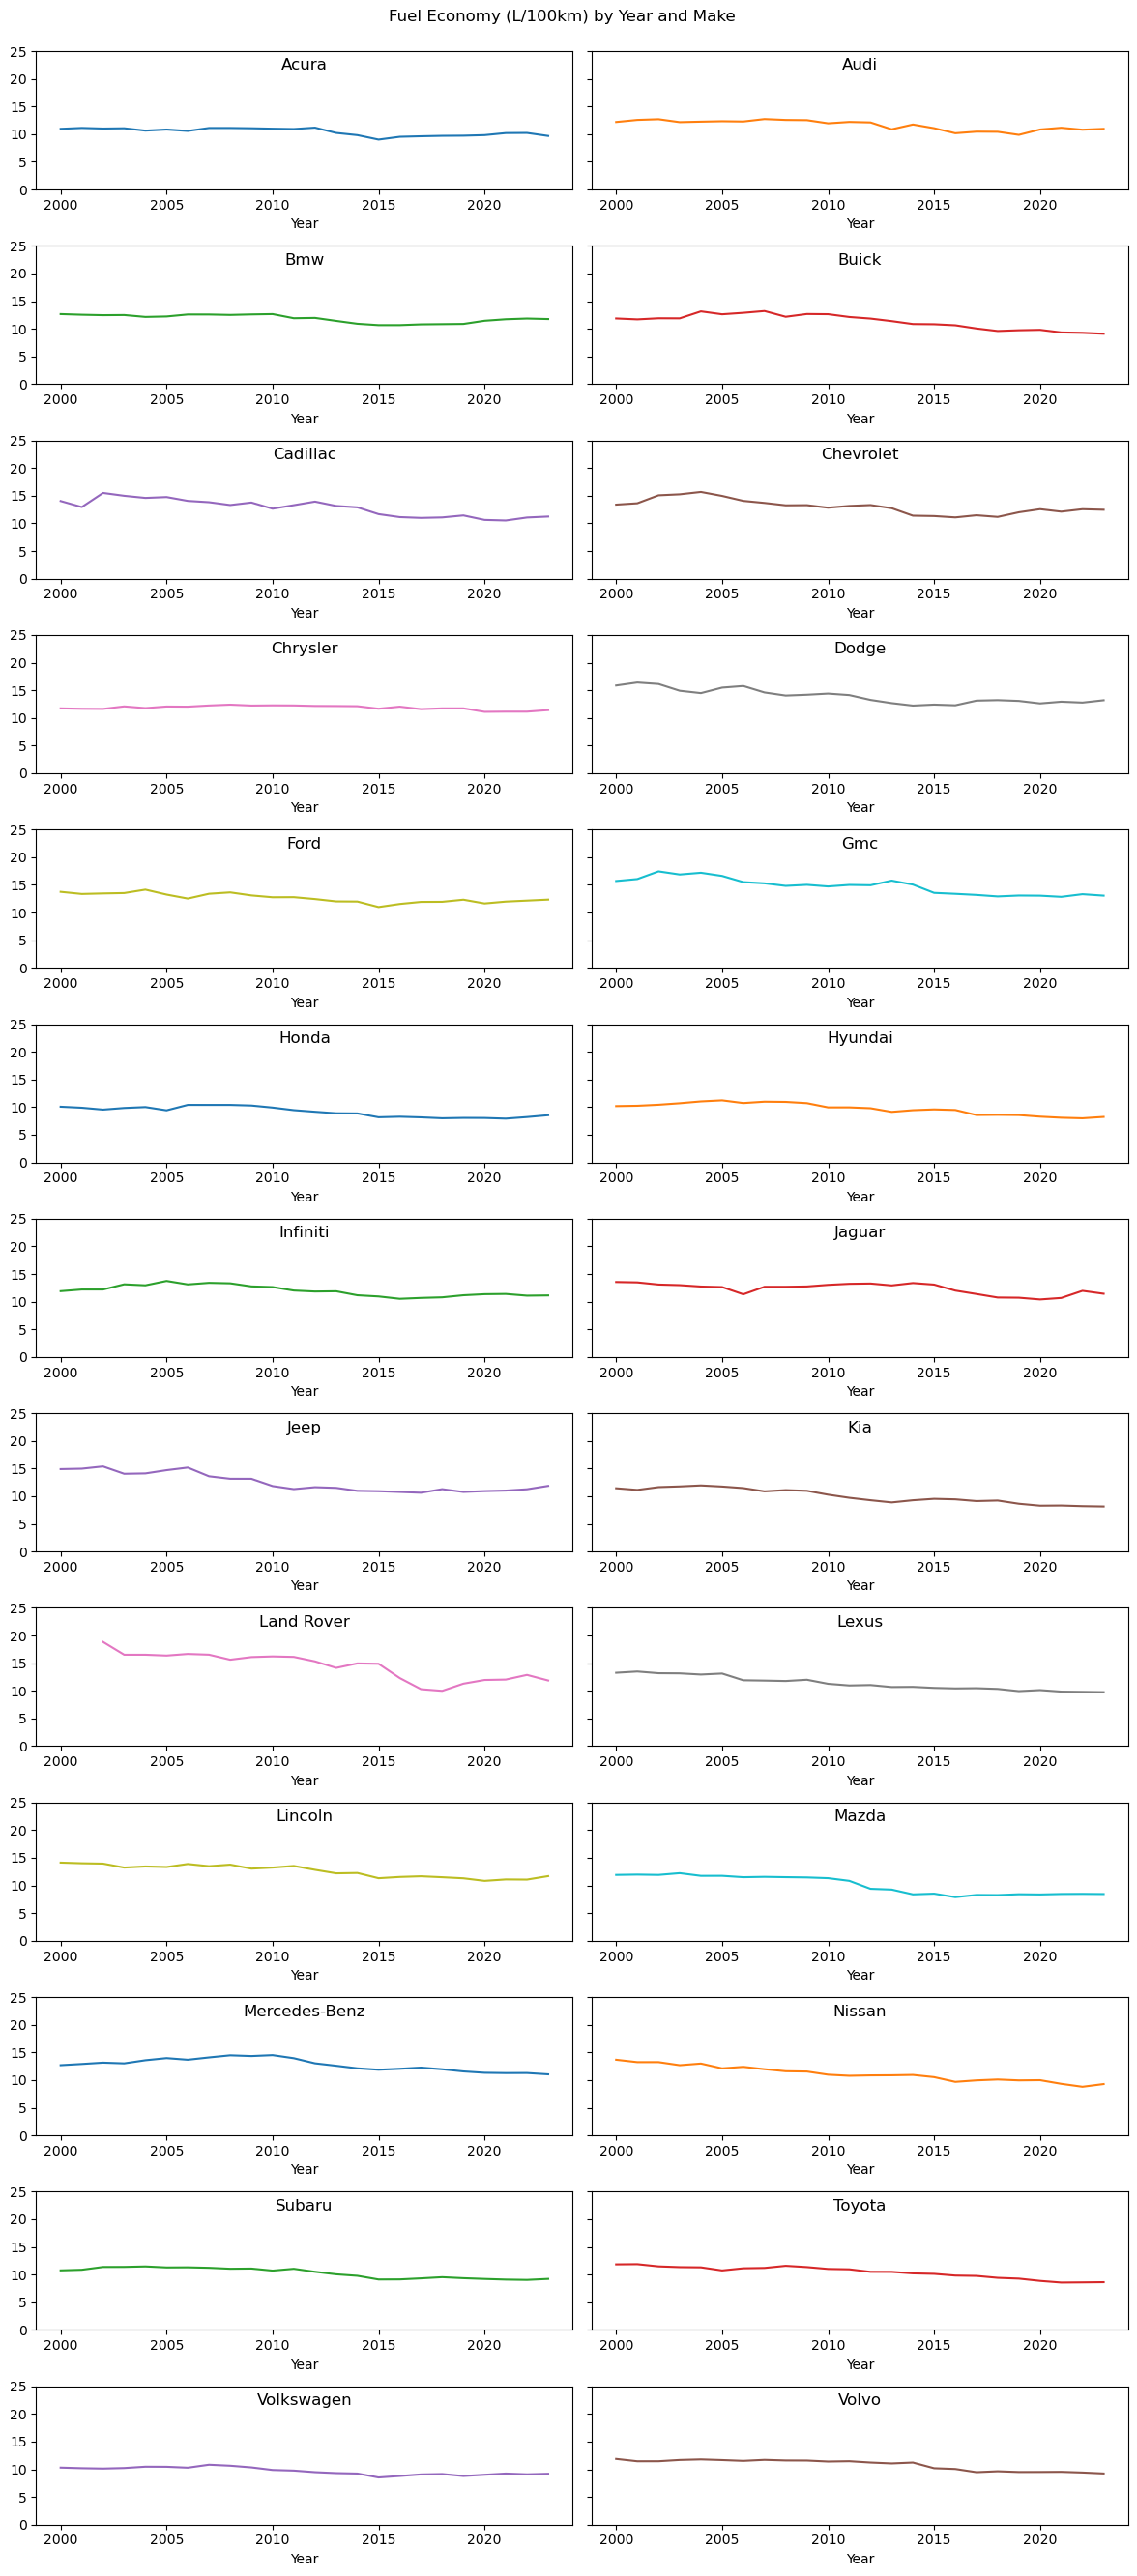

In [823]:
fuel_economy_by_year_and_make = full_dataset.pivot_table(index="model_year", columns="make", values="comb_lpkm", aggfunc="mean")

axs = fuel_economy_by_year_and_make.plot.line(
    figsize=(12, 28), subplots=True, legend=False, sharex=False,
    sharey=True, layout=(13, 2), grid=False, xlabel="Year"
)

axs[0,0].get_figure().tight_layout(rect=[0, 0.03, 1, 0.97])
axs[0,0].get_figure().suptitle('Fuel Economy (L/100km) by Year and Make')
axs = axs.flatten()
titles = fuel_economy_by_year_and_make.columns
i = 0
for ax in axs:
    title = titles[i]
    ax.set_title(title, y=1.0, pad=-14)
    ax.set_ylim(0, 25)
    i += 1

In [825]:
fuel_economy_by_year_make_and_vehicle_type = full_dataset.pivot_table(index=["model_year", "make"], columns="vehicle_class", values="comb_lpkm", aggfunc="mean")

fuel_economy_by_year_make_and_vehicle_type.reset_index(["model_year"], inplace=True)
fuel_economy_by_year_make_and_vehicle_type

by_year = fuel_economy_by_year_make_and_vehicle_type.groupby("model_year")
by_year.idxmin()

vehicle_class,Car,SUV,Truck,Van
model_year,,,,
2000,Honda,Subaru,Nissan,Chevrolet
2001,Honda,Subaru,Toyota,Chevrolet
2002,Honda,Subaru,Mazda,Chevrolet
2003,Honda,Subaru,Toyota,Chevrolet
2004,Honda,Mazda,Mazda,Dodge
2005,Honda,Subaru,Mazda,Honda
2006,Honda,Subaru,Mazda,Honda
2007,Toyota,Subaru,Mazda,Toyota
2008,Toyota,Subaru,Mazda,Mazda


# Improvement by company

In [826]:
#Ford
ford_dataset = full_dataset.loc[full_dataset['make'] == 'Ford']
ford_dataset = ford_dataset[['model_year', 'vehicle_class','comb_lpkm']]
ford_dataset = ford_dataset.set_index("model_year").sort_index()
ford_dataset = ford_dataset.pivot_table(index="model_year", columns="vehicle_class", 
                                            values="comb_lpkm", aggfunc="mean")
ford_dataset

vehicle_class,Car,SUV,Truck,Van
model_year,,,,
2000,11.240000,15.741667,15.216667,13.500
2001,11.254545,14.400000,15.045455,13.000
2002,11.190909,14.630000,15.033333,13.300
2003,11.646154,14.320000,15.096154,13.300
2004,11.585185,15.150000,16.400000,13.900
2005,11.958333,13.038462,15.094444,13.500
2006,11.205556,12.233333,14.378571,13.800
2007,12.160870,12.023077,15.477273,13.600
2008,12.429412,12.008333,15.312500,NaN


In [827]:
#grouping to clean up the plot, if we want to do that 
ford_grouped_dataset = pd.DataFrame()

ford_grouped_dataset["Sedan"] = ford_dataset[['Compact', 'Full-size', 'Mid-size', 'Subcompact']].mean(axis=1)
ford_grouped_dataset['SUV'] = ford_dataset[['SUV', 'SUV: Small','SUV: Standard']].mean(axis=1)
ford_grouped_dataset['Truck'] = ford_dataset[['Pickup truck: Small', 'Pickup truck: Standard']].mean(axis=1)

#don't have station wagon or minivan for most years so omitting
#ford_grouped_dataset['Minivan'] = ford_dataset['Minivan']
#ford_grouped_dataset['Station Wagon'] = ford_dataset['Station wagon: Mid-size']
ford_grouped_dataset

KeyError: "None of [Index(['Compact', 'Full-size', 'Mid-size', 'Subcompact'], dtype='object', name='vehicle_class')] are in the [columns]"

In [ ]:
#adding financials 
ford_grouped_dataset['R&D Expense'] = ford_grouped_dataset.index.map(ford_rnd)
ford_grouped_dataset

NameError: name 'ford_rnd' is not defined

Text(500, 50, 'The Great Financial Crisis hits \n the american auto industry')

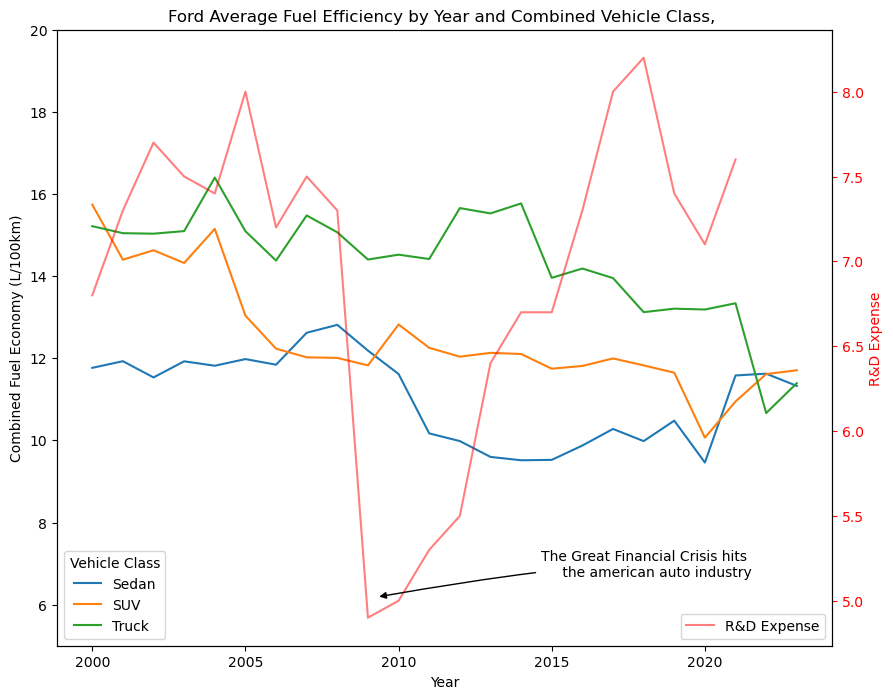

In [ ]:
fig, ax = plt.subplots(figsize=(10,8))

ford_grouped_dataset[['Sedan', 'SUV', 'Truck']].plot.line(ax=ax)
ax.set_xlabel("Year")
ax.set_ylabel("Combined Fuel Economy (L/100km)")
ax.set_ylim(5, 20)
ax.set_title("Ford Average Fuel Efficiency by Year and Combined Vehicle Class, ")
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels, title="Vehicle Class", loc='lower left')

ax_rnd = ax.twinx()
ax_rnd = ford_grouped_dataset['R&D Expense'].plot.line(color='red', alpha=0.5)
ax_rnd.set_ylabel('R&D Expense', color='r')
ax_rnd.tick_params(colors='r')
handles, labels = ax_rnd.get_legend_handles_labels()
ax_rnd.legend(handles, labels, loc='lower right') 
ax_rnd.annotate("The Great Financial Crisis hits \n the american auto industry", xy=(230, 35), 
                xycoords='axes points', xytext=(500, 50), annotation_clip=False, 
                horizontalalignment="right", arrowprops={
                    "arrowstyle": "-|>", "connectionstyle": "angle3,angleA=0,angleB=10", "color": "black"}, 
                fontsize=10)

# Retrieving RnD Expense

In [ ]:
! pip install tabula-py

In [ ]:
import tabula
from datetime import datetime

In [ ]:
#scraping earnings data

#feed in URL and extract all tables from the pdf
url = "https://global.toyota/pages/global_toyota/ir/financial-results/archives/en/May_9_2007_consolidated.pdf"
all_dfs = tabula.read_pdf(url, pages='all', multiple_tables=True)
#print(all_dfs)

In [ ]:
#find the table which contains the R&D expenses
for df in all_dfs:
    if ('R&D Expenses (billions of yen)' in df.values) or (
        'Research & Development (billions of yen)' in df.values):
        RnD_df = df
        RnD_df.reset_index(drop=True, inplace=True)
        break
        
RnD_df = RnD_df.set_index(RnD_df.columns[0])
#print(RnD_df)

In [ ]:
#get full-year cols
#most pdfs have a col for 12 months/12 mos. ended so it's easy. For ones that dont, just going to look for 
#high nums which is a bit of a crappy workaround but good enough for now. Might want to find a better way later
#though since this won't be generalizable going way back 
check_format = RnD_df.loc[:, RnD_df.apply(lambda x: ('12 months' in x.values) or ('12 mos. ended' in x.values))]
if len(check_format.columns) != 0:
    filtered_RnD_df = RnD_df.loc[:, RnD_df.apply(lambda x: ('12 months' in x.values) or ('12 mos. ended' in x.values))]
else:
    try: 
        RnD_df = RnD_df.loc[:,RnD_df.loc["R&D Expense (billions of yen)"].notna()]
        filtered_RnD_df = RnD_df.iloc[:, [4, 9]]
    except KeyError: 
        try: 
            RnD_df = RnD_df.loc[:,RnD_df.loc["Research & Development (billions of yen)"].notna()]
            filtered_RnD_df = RnD_df.iloc[:, [4, 9]]
        except: print("No col found")

#remove the forecast col if present, sometimes it seems to be the column title and sometimes just in one of
#.  the first rows. Removing both just in case. 
forecast_col = filtered_RnD_df.applymap(lambda x: "Forecast" in str(x)).any()
filtered_RnD_df = filtered_RnD_df.drop(columns=filtered_RnD_df.columns[forecast_col])
if "Forecast" in filtered_RnD_df:
    filtered_RnD_df = filtered_RnD_df.drop(["Forecast"], axis=1)

#print(filtered_RnD_df)

/var/folders/cg/wggrqqlj4q52bf4vs_n4nmzw0000gn/T/ipykernel_4255/4147236158.py:5: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  check_format = RnD_df.loc[:, RnD_df.apply(lambda x: ('12 months' in x.values) or ('12 mos. ended' in x.values))]


In [ ]:
filtered_RnD_df = filtered_RnD_df.dropna(how='all')

fiscal_yr = []

filtered_RnD_df = filtered_RnD_df.dropna()

old_dates = filtered_RnD_df.loc[filtered_RnD_df.iloc[:,1].str.contains("FY")].values.tolist()
if len(old_dates) != 0:
    for date in old_dates[0]:
        year = int(date[2:6])
        fiscal_yr.append(year)
elif len(filtered_RnD_df.loc[filtered_RnD_df.iloc[:,1].str.contains("'")].values.tolist()) != 0:
    date_values = filtered_RnD_df.loc[filtered_RnD_df.iloc[:,0].str.contains("'")].values
    for date_range in date_values[0].tolist():
        end_date_yr = date_range[8:10]
        year = int(end_date_yr) + 2000
        fiscal_yr.append(year)
else:
    try:
        date1 = int(all_dfs[0].iloc[:,0][6][2:])    #int(filtered_RnD_df.iloc[0,0][4:8])
    except ValueError:
        date1 = int(all_dfs[0].columns[2][2:])
    date2 = date1 + 1
    fiscal_yr.append(date1)
    fiscal_yr.append(date2)
        
filtered_RnD_df.columns = fiscal_yr

In [ ]:
#extract to dict

if ("R&D Expenses (billions of yen)") in filtered_RnD_df.index:
    toyota_rnd_expenses = filtered_RnD_df.loc["R&D Expenses (billions of yen)"]
elif ('Research & Development (billions of yen)') in filtered_RnD_df.index:
    toyota_rnd_expenses = filtered_RnD_df.loc['Research & Development (billions of yen)']
    
toyota_rnd_dict = toyota_rnd_expenses.to_dict()
#print(toyota_rnd_dict)

## Copying the above into a single function:

In [ ]:
! pip install tabula-py

In [ ]:
import tabula
from datetime import datetime

In [ ]:
#TEST
def retrieve_toyota_rnd_exp(url):
    """
    Parse the RnD Expense for each year from the given url (pdf file of Toyota earnings)
    Returns a dict with years and RnD expense (billions of yen)
    
    **Only seems to work on some pdfs right now (even though they look the same visually they load
    with slightly different columns it seems...). Can try to update later to be more general.
    
    """
    #scraping earnings data

    #feed in URL and extract all tables from the pdf
    all_dfs = tabula.read_pdf(url, pages='all', multiple_tables=True)
    
    #find the table which contains the R&D expenses
    for df in all_dfs:
        if ('R&D Expenses (billions of yen)' in df.values) or (
            'Research & Development (billions of yen)' in df.values):
            RnD_df = df
            RnD_df.reset_index(drop=True, inplace=True)
            break

    RnD_df = RnD_df.set_index(RnD_df.columns[0])
    
    #get full-year cols
    #most pdfs have a col for 12 months/12 mos. ended so it's easy. For ones that dont, just going to look for 
    #high nums which is a bit of a crappy workaround but good enough for now. Might want to find a better way later
    #though since this won't be generalizable going way back 
    check_format = RnD_df.loc[:, RnD_df.apply(lambda x: ('12 months' in x.values) or ('12 mos. ended' in x.values))]
    if len(check_format.columns) != 0:
        filtered_RnD_df = RnD_df.loc[:, RnD_df.apply(lambda x: ('12 months' in x.values) or ('12 mos. ended' in x.values))]
    else:
        RnD_df = RnD_df.loc[:,RnD_df.loc["R&D Expenses (billions of yen)"].notna()]
        filtered_RnD_df = RnD_df.iloc[:, [4, 9]]

    #remove the forecast col if present, sometimes it seems to be the column title and sometimes just in one of
    #.  the first rows. Removing both just in case. 
    forecast_col = filtered_RnD_df.applymap(lambda x: "Forecast" in str(x)).any()
    filtered_RnD_df = filtered_RnD_df.drop(columns=filtered_RnD_df.columns[forecast_col])
    if "Forecast" in filtered_RnD_df:
        filtered_RnD_df = filtered_RnD_df.drop(["Forecast"], axis=1)
    
    #set col names to year 
    #find row with date - only row which contains an apostrophe is date row
    #had to drop NaNs first or else error
    filtered_RnD_df = filtered_RnD_df.dropna(how='all')

    fiscal_yr = []

    filtered_RnD_df = filtered_RnD_df.dropna()

    old_dates = filtered_RnD_df.loc[filtered_RnD_df.iloc[:,1].str.contains("FY")].values.tolist()
    if len(old_dates) != 0:
        for date in old_dates[0]:
            year = int(date[2:6])
            fiscal_yr.append(year)
    elif len(filtered_RnD_df.loc[filtered_RnD_df.iloc[:,1].str.contains("'")].values.tolist()) != 0:
        date_values = filtered_RnD_df.loc[filtered_RnD_df.iloc[:,0].str.contains("'")].values
        for date_range in date_values[0].tolist():
            end_date_yr = date_range[8:10]
            year = int(end_date_yr) + 2000
            fiscal_yr.append(year)
    else:
        date1 = int(all_dfs[0].iloc[:,0][6][2:])    #int(filtered_RnD_df.iloc[0,0][4:8])
        date2 = date1 + 1
        fiscal_yr.append(date1)
        fiscal_yr.append(date2)

    filtered_RnD_df.columns = fiscal_yr
    
    #extract to dict
    if ("R&D Expenses (billions of yen)") in filtered_RnD_df.index:
        toyota_rnd_expenses = filtered_RnD_df.loc["R&D Expenses (billions of yen)"]
    elif ('Research & Development (billions of yen)') in filtered_RnD_df.index:
        toyota_rnd_expenses = filtered_RnD_df.loc['Research & Development (billions of yen)']

    toyota_rnd_dict = toyota_rnd_expenses.to_dict()
    
    return toyota_rnd_dict

In [ ]:
toyota_rnd_21_22 = retrieve_toyota_rnd_exp("https://global.toyota/pages/global_toyota/ir/financial-results/2022_4q_summary_en.pdf")
toyota_rnd_20_21 =  retrieve_toyota_rnd_exp("https://global.toyota/pages/global_toyota/ir/financial-results/2021_4q_summary_en.pdf")
toyota_rnd_19_20 = retrieve_toyota_rnd_exp("https://global.toyota/pages/global_toyota/ir/financial-results/2020_4q_summary_en.pdf")
toyota_rnd_18_19 = retrieve_toyota_rnd_exp("https://global.toyota/pages/global_toyota/ir/financial-results/2019_4q_summary_en.pdf")
toyota_rnd_17_18 = retrieve_toyota_rnd_exp("https://global.toyota/pages/global_toyota/ir/financial-results/archives/en/May_9_2018_summary.pdf")
#2017 doesnt work (https://global.toyota/pages/global_toyota/ir/financial-results/archives/en/May_10_2017_consolidated.pdf)
toyota_rnd_15_16 = retrieve_toyota_rnd_exp("https://global.toyota/pages/global_toyota/ir/financial-results/archives/en/May_11_2016_consolidated.pdf")
toyota_rnd_14_15 = retrieve_toyota_rnd_exp("https://global.toyota/pages/global_toyota/ir/financial-results/archives/en/May_8_2015_consolidated.pdf")
toyota_rnd_13_14 = retrieve_toyota_rnd_exp("https://global.toyota/pages/global_toyota/ir/financial-results/archives/en/May_8_2014_consolidated.pdf")
toyota_rnd_12_13 = retrieve_toyota_rnd_exp("https://global.toyota/pages/global_toyota/ir/financial-results/archives/en/May_8_2013_consolidated.pdf")
toyota_rnd_11_12 = retrieve_toyota_rnd_exp("https://global.toyota/pages/global_toyota/ir/financial-results/archives/en/May_9_2012_consolidated.pdf")
toyota_rnd_10_11 = retrieve_toyota_rnd_exp("https://global.toyota/pages/global_toyota/ir/financial-results/archives/en/May_11_2011_consolidated.pdf")
toyota_rnd_09_10 = retrieve_toyota_rnd_exp("https://global.toyota/pages/global_toyota/ir/financial-results/archives/en/May_11_2010_consolidated.pdf")
toyota_rnd_08_09 = retrieve_toyota_rnd_exp("https://global.toyota/pages/global_toyota/ir/financial-results/archives/en/May_8_2009_consolidated.pdf")
toyota_rnd_07_08 = retrieve_toyota_rnd_exp("https://global.toyota/pages/global_toyota/ir/financial-results/archives/en/May_8_2008_consolidated.pdf")
#2007 doesn't work ()

Got stderr: Apr. 03, 2023 11:53:59 A.M. org.apache.fontbox.ttf.CmapSubtable processSubtype14
Apr. 03, 2023 11:54:00 A.M. org.apache.fontbox.ttf.CmapSubtable processSubtype14
Apr. 03, 2023 11:54:00 A.M. org.apache.fontbox.ttf.CmapSubtable processSubtype14
Apr. 03, 2023 11:54:00 A.M. org.apache.fontbox.ttf.CmapSubtable processSubtype14
Apr. 03, 2023 11:54:00 A.M. org.apache.fontbox.ttf.CmapSubtable processSubtype14

Got stderr: Apr. 03, 2023 11:54:06 A.M. org.apache.fontbox.ttf.CmapSubtable processSubtype14
Apr. 03, 2023 11:54:06 A.M. org.apache.fontbox.ttf.CmapSubtable processSubtype14
Apr. 03, 2023 11:54:06 A.M. org.apache.fontbox.ttf.CmapSubtable processSubtype14

/var/folders/cg/wggrqqlj4q52bf4vs_n4nmzw0000gn/T/ipykernel_4255/1000738884.py:30: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  check_format = RnD_df.loc[:, RnD_df.apply(lambda x: ('12 months' in x.values) or ('12 mos. ended' in x.values))]
Got

In [ ]:
#test cell
#retrieve_toyota_rnd_exp("")

In [ ]:
print(toyota_rnd_21_22)
print(toyota_rnd_20_21)
print(toyota_rnd_19_20)
print(toyota_rnd_18_19)
print(toyota_rnd_17_18)
print(toyota_rnd_15_16)
print(toyota_rnd_14_15)
print(toyota_rnd_13_14)
print(toyota_rnd_12_13)
print(toyota_rnd_11_12)
print(toyota_rnd_10_11)
print(toyota_rnd_09_10)
print(toyota_rnd_08_09) #dicrepancy here! there's two RnD expense values in the PDF for Japan/USA GAAP... 
print(toyota_rnd_07_08)

{2021: '1,090.4', 2022: '1,124.2'}
{2020: '1,110.3', 2021: '1,090.4'}
{2019: '1,048.8', 2020: '1,110.3'}
{2018: '1,064.2', 2019: '1,048.8'}
{2017: '1,037.5', 2018: '1,064.2'}
{2015: '1,004.5', 2016: '1,055.6'}
{2014: '910.5', 2015: '1,004.5'}
{2013: '807.4', 2014: '910.5'}
{2012: '779.8', 2013: '807.4'}
{2011: '730.3', 2012: '779.8'}
{2010: '725.3', 2011: '730.3'}
{2009: '904.0', 2010: '725.3'}
{2008: '818.5', 2009: '769.8'}
{2007: '890.7', 2008: '958.8'}


In [ ]:
#ford reports this as "Engineering, research, and development" in billions USD
# from: https://shareholder.ford.com/Investors/financials/default.aspx#annual-reports
ford_rnd = {
    2021: 7.6,
    2020: 7.1,
    2019: 7.4,
    2018: 8.2,
    2017: 8.0,
    2016: 7.3,
    2015: 6.7, 
    2014: 6.7,
    2013: 6.4,
    2012: 5.5,
    2011: 5.3,
    2010: 5.0,
    2009: 4.9,
    2008: 7.3,
    2007: 7.5,
    2006: 7.2,
    2005: 8.0,
    2004: 7.4,
    2003: 7.5, 
    2002: 7.7,
    2001: 7.3,
    2000: 6.8
    
}

In [ ]:
#Hyundai reports this as Total Research and development costs in millions of Korean Won
# from: https://www.hyundai.com/worldwide/en/company/ir/financial-information/financial-statements
#changed reporting before 2005 so not sure we'll find comparable data for those years
hyundai_rnd = {
    2022: 3_336_573,
    2021: 3_097_897,
    2020: 3_097_061,
    2019: 3_021_683,
    2018: 2_742_378,
    2017: 2_487_771,
    2016: 2_352_229,
    2015: 2_172_406,
    2014: 2_128_904,
    2013: 1_849_044,
    2012: 1_631_670,
    2011: 1_445_268,
    2010: 1_388_776,
    2009: 1_274_549,
    2008: 1_176_634,
    2007: 1_064_210,
    2006: 1_047_200,
    2005: 1_002_280,
}

In [ ]:
#GM(chevy) reports as research and development expenses in billion USD
#from: https://investor.gm.com/sec-filings?field_nir_sec_form_group_target_id%5B%5D=471&field_nir_sec_date_filed_value=#views-exposed-form-widget-sec-filings-table
#no data before 2007
gm_rnd = {
    2022: 9.8,
    2021: 7.9, 
    2020: 6.2,
    2019: 6.8,
    2018: 7.8,
    2017: 7.3, 
    2016: 6.6,
    2015: 6.0,
    2014: 7.4,
    2013: 7.2,
    2012: 7.4,
    2011: 8.1,
    2010: 7.0,
    2009: 3.0,
    2008: 8.0,
    2007: 8.1,
    2006: 6.6,
    2005: 6.7,
    2004: 6.5,
    2003: 6.2,
    2002: 6.0,
    2001: 6.1,
    2000: 6.0
}

In [ ]:
#Honda reports in millions (yen)
# from: https://global.honda/investors/library/financialresult.html
#nothing beyond 2012 on their website
honda_rnd = {
    2022: 787_056,
    2021: 738_894, 
    2020: 804_123,
    2019: 806_905,
    2018: 751_856,
    2017: 691_429,
    2016: 656_502,
    2015: 606_162,
    2014: 634_130,
    2013: 560_270,
    2012: 519_818,
    2011: 487_591,
    2010: 463_354,
    2009: 563_197,
    2008: 587_959,
    2007: 551_847, 
    2006: 510_385,
    2005: 467_754,
    2004: 448_967,
    2003: 436_863,
    2002: 395_176,
    2001: 352_829,
    2000: 334_036
}

In [ ]:
# Stellantis owns fiat, crysler, jeep, dodge, Maserati, RAM, alfa romeo...
#Technically Stellantis was formed from a merger only in 2021. Before 2014-2021 was Fiat Chrysler, before that
# Chrysler Group LLC (2009-2014) and Chrysler LLC (2007-2009), DaimlerChrysler (1998-2007)... 
# history of M&A is too conveluded to provide useful data I think
# the reported numbers I can find are all over the place
stellantis_rnd = {
    2021: ,
    2020: ,
    2019: 3_612,
    2018: 3_051,
    2017: 3_230,
    2016: 3_274,
    2015: 2_864, 
    2014: 2_537,
    2013: 2_236,
    2012: 1_858,
    2011: 
}

In [ ]:
#Nissan reports in billions of yen
#from: https://www.nissan-global.com/EN/IR/LIBRARY/
nissan_rnd = {
    2021: 484.1,
    2020: 503.5,
    2019: 544.8,
    2018: 523.1,
    2017: 495.8,
    2016: 490.4,
    2015: 531.9,
    2014: 506.1,
    2013: 500.6,
    2012: 469.9,
    2011: 428.0,
    2010: 399.3,
    2009: 385.5,
    2008: 455.5,
    2007: 457.5,
    2006: 464.8,
    2005: 447.6,
    2004: 398.1,
    2003: 354.3,
    2002: 300.3,
    2001: 262.1,
    2000: 231.7
}

In [ ]:
# Kia reports in units of 100m KRW
# from: https://worldwide.kia.com/int/company/ir/archive/annual-report?p=1
kia_rnd = {
    2021: 18_719,
    2020: 16_730,
    2019: 17_682,
    2018: 16_649,
    2017: 16_419,
    2016: 16_464,
    2015: 15_235,
    2014: 12_699,
    2013: 12_415,
    2012: 10_270,
    2011: 9_922,
    2010: 8_673,
    2009: 7_146,
    2008: 7_481,
    2007: 5_971,
    2006: 5_681,
    2005: 5_657,
    2004: 5_386,
    2003: 4_275,
    2002: 3_925,
    2001: 1_143,
    2000: 734,
}

In [ ]:
#Volvo reports in units of millions of SEK (Swedish Krona)
# from: https://www.volvogroup.com/en/investors/reports-and-presentations/annual-reports.html

volvo_rnd = {
    2022: 22_526,
    2021: 18_027, 
    2020: 16_798,
    2019: 18_539,
    2018: 15_899,
    2017: 16_098,
    2016: 14_631,
    2015: 15_368,
    2014: 16_656
    2013: 15_124,
    2012: 14_794,
    2011: 13_276,
    2010: 13_000,
    2009: 13_200,
    2008: 14_300,
    2007: 11_100,
    2006: 8_400,
    2005: 7_600,
    2004: 7_600,
    2003: 6_800,
    2002: 5_900,
    2001: 5_400,
    2000: 4_876
}

In [ ]:
#Mercedes Benz Group reports in billions of euros
# from: https://group.mercedes-benz.com/investors/reports-news/annual-reports/download/

mercedes_rnd = {
    2022: 8.5,
    2021: 9.1,
    2020: 8.614,
    2019: 9.662,
    2018: 9.107,
    2017: 8.711 ,
    2016: 7.572,
    2015: 6.564,
    2014: 5.680,
    2013: 5.489,
    2012: 5.644,
    2011: 5.634,
    2010: 4.849,
    2009: 4.181,
    2008: 4.442,
    2007: 4.148,
    2006: 5.331,
    2005: 5.649,
    2004: 5.658,
    2003: 5.571,
    2002: 5.942,
    2001: 5.848,
    2000: 7.395
}

## Old code:

In [ ]:
def retrieve_toyota_rnd_exp(url):
    """
    Parse the RnD Expense for each year from the given url (pdf file of Toyota earnings)
    Returns a dict with years and RnD expense (billions of yen)
    
    **Only seems to work on some pdfs right now (even though they look the same visually they load
    with slightly different columns it seems...). Can try to update later to be more general.
    
    """
    #scraping earnings data

    #feed in URL and extract all tables from the pdf
    all_dfs = tabula.read_pdf(url, pages='all', multiple_tables=True)
    
    #find the table which contains the R&D expenses
    for df in all_dfs:
        if ('R&D Expenses (billions of yen)' in df.values) or (
            'Research & Development (billions of yen)' in df.values):
            RnD_df = df
            RnD_df.reset_index(drop=True, inplace=True)
            break

    RnD_df = RnD_df.set_index(RnD_df.columns[0])
    
    #get full-year cols
    filtered_RnD_df = RnD_df.loc[:, RnD_df.apply(lambda x: ('12 months' in x.values) or (
        '12 mos. ended' in x.values))]

    #remove the forecast col if present, sometimes it seems to be the column title and sometimes just in one of
    #.  the first rows. Removing both just in case. 
    forecast_col = filtered_RnD_df.applymap(lambda x: "Forecast" in str(x)).any()
    filtered_RnD_df = filtered_RnD_df.drop(columns=filtered_RnD_df.columns[forecast_col])
    if "Forecast" in filtered_RnD_df:
        filtered_RnD_df = filtered_RnD_df.drop(["Forecast"], axis=1)
    
    #set col names to year 
    #find row with date - only row which contains an apostrophe is date row
    #had to drop NaNs first or else error
    filtered_RnD_df = filtered_RnD_df.dropna(how='all')

    fiscal_yr = []

    old_dates = filtered_RnD_df.loc[filtered_RnD_df.iloc[:,0].str.contains("FY")].values.tolist()
    if len(old_dates) != 0:
        for date in old_dates[0]:
            year = int(date[2:6])
            fiscal_yr.append(year)
    else:
        date_values = filtered_RnD_df.loc[filtered_RnD_df.iloc[:,0].str.contains("'")].values
        for date_range in date_values[0].tolist():
            end_date_yr = date_range[8:10]
            year = int(end_date_yr) + 2000
            fiscal_yr.append(year)

    filtered_RnD_df.columns = fiscal_yr   
    
    #extract to dict
    if ("R&D Expenses (billions of yen)") in filtered_RnD_df.index:
        toyota_rnd_expenses = filtered_RnD_df.loc["R&D Expenses (billions of yen)"]
    elif ('Research & Development (billions of yen)') in filtered_RnD_df.index:
        toyota_rnd_expenses = filtered_RnD_df.loc['Research & Development (billions of yen)']

    toyota_rnd_dict = toyota_rnd_expenses.to_dict()
    
    return toyota_rnd_dict

In [ ]:
#filtered_RnD_df = float(str(RnD_df.loc[RnD_df.index[1]]).replace(",",""))
#for x in filtered_RnD_df.values:
#    print(float(str(x).replace(",", "")))

def remove_commas(s):
    if isinstance(s, str):
        return s.replace(',', '')
    else:
        return s

RnD_df = RnD_df.applymap(remove_commas)
RnD_df = RnD_df.fillna(-1)
#RnD_df = RnD_df.drop(columns=RnD_df.columns[0])
RnD_df.loc["R&D Expenses (billions of yen)"] = RnD_df.loc["R&D Expenses (billions of yen)"].astype(float)

RnD_df_filtered = RnD_df.loc["R&D Expenses (billions of yen)"] >= 500
RnD_df_filtered

KeyError: 'R&D Expenses (billions of yen)'